# Topic Modeling

Extracting topics from a collection of documents.

In [1]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [2]:
%%capture
%pylab inline
import pandas as pd
import os
%load_ext rpy2.ipython
from IPython.display import Image

## Topic Modeling using LDA

This is a nice article that has most of what is needed: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

## LDA Explained (Briefly)

Latent Dirichlet Allocation (LDA) was created by David Blei, Andrew Ng, and Michael Jordan in 2003, see their paper titled "Latent Dirichlet Allocation" in the *Journal of Machine Learning Research*, pp 993--1022: http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

The simplest way to think about LDA is as a probability model that connects documents with words and topics. The components are:

- A Vocabulary of $V$ words, i.e., $w_1,w_2,...,w_i,...,w_V$, each word indexed by $i$.
- A Document is a vector of $N$ words, i.e., ${\bf w}$.
- A Corpus $D$ is a collection of $M$ documents, each document indexed by $j$, i.e. $d_j$.

Next, we connect the above objects to $K$ topics, indexed by $l$, i.e., $t_l$.  We will see that LDA is encapsulated (conceptually) in two matrices: Matrix $A$ and Matrix $B$.  

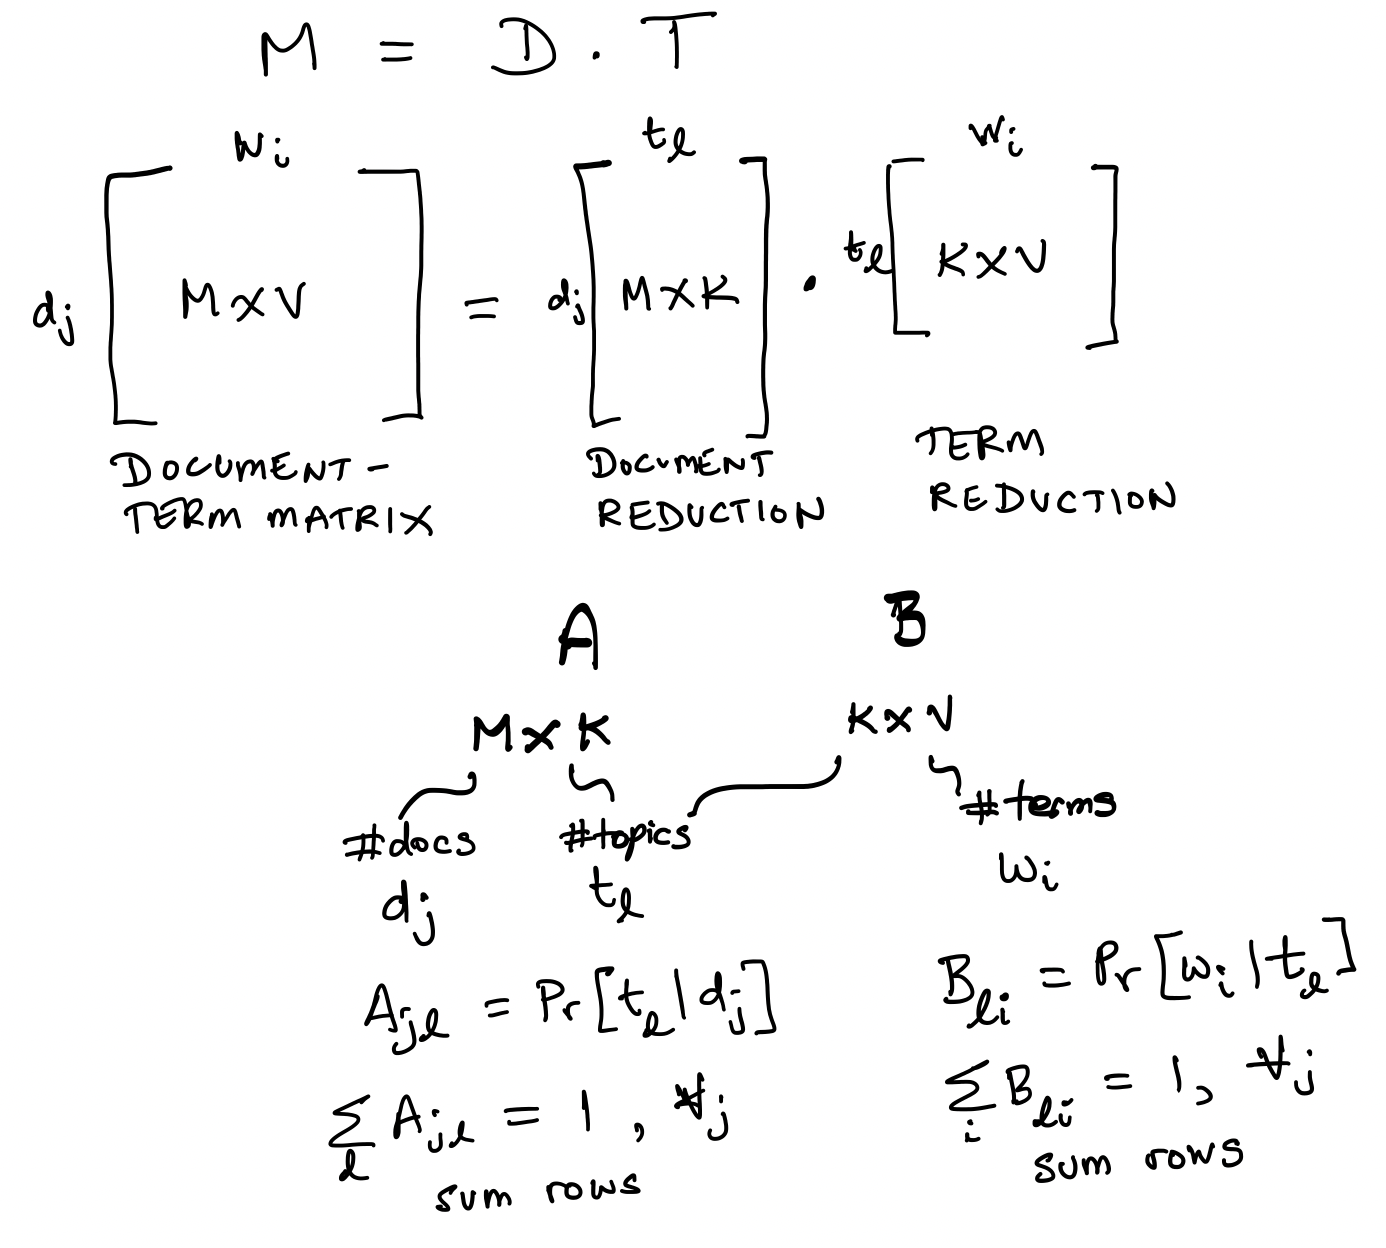

In [ ]:
## LDA Decomposition

Image('NLP_images/LDA_decomp.png', width=800)

## Matrix $A$: Connecting Documents with Topics

- This matrix has documents on the rows, so there are $M$ rows.
- The topics are on the columns, so there are $K$ columns.
- Therefore $A \in {R}^{M \times K}$.
- The row sums equal $1$, i.e., for each document, we have a probability that it pertains to a given topic, i.e., $A_{jl} = Pr[t_l | d_j]$, and $\sum_{l=1}^K A_{jl} = 1$.

## Matrix $B$: Connecting Words with Topics

- This matrix has topics on the rows, so there are $K$ rows.
- The words are on the columns, so there are $V$ columns.
- Therefore $B \in {R}^{K \times V}$.
- The row sums equal $1$, i.e., for each topic, we have a probability that it pertains to a given word, i.e., $B_{li} = Pr[w_i | t_l]$, and $\sum_{i=1}^V B_{li} = 1$.

## Distribution of Topics in a Document

- This is a [*generative*](https://en.wikipedia.org/wiki/Generative_model) model, i.e., we have a prior on topics in documents from which we sample to create a topic vector with probabilities of dimension $K$, adding up to 1. (Compare this to *discriminative* models.)
- Using Matrix $A$, we can sample a $K$-vector of probabilities of topics for a single document. Denote the probability of this vector as $p(\theta | \alpha)$, where $\theta, \alpha \in {R}^K$, $\theta, \alpha \geq 0$, and $\sum_l \theta_l = 1$.  
- The probability $p(\theta | \alpha)$ is governed by a Dirichlet distribution, with density function

$$
p(\theta | \alpha) = \frac{\Gamma(\sum_{l=1}^K \alpha_l)}{\prod_{l=1}^K \Gamma(\alpha_l)} \; \prod_{l=1}^K \theta_l^{\alpha_l - 1}
$$

where $\Gamma(\cdot)$ is the Gamma function.
- LDA thus gets its name from the use of the Dirichlet distribution, embodied in Matrix $A$. Since the topics are latent, it explains the rest of the nomenclature.
- Given $\theta$, we sample topics from matrix $A$ with probability $p(t | \theta)$.

Note: https://en.wikipedia.org/wiki/Dirichlet_distribution

In [4]:
# Dirichlet Basics
alpha = rand(5) # concentration parameters
print("alpha=",alpha)
theta = array([0.1,0.2,0.4,0.2,0.1])  # topic mixture

from scipy.stats import dirichlet
print("PDF of theta =",dirichlet.pdf(theta, alpha))
print("Draw a random theta =",dirichlet.rvs(alpha).round(2))

alpha= [0.85850659 0.83998973 0.96563454 0.55577837 0.47638793]
PDF of theta = 13.922198401624465
Draw a random theta = [[0.13 0.05 0.26 0.04 0.53]]


## Distribution of Words and Topics for a Document

- And then, a generative model for words.
- The number of words in a document is assumed to be distributed Poisson with parameter $\xi$.
- Matrix $B$ gives the [*multinomial*](https://en.wikipedia.org/wiki/Multinomial_distribution#:~:text=In%20probability%20theory%2C%20the%20multinomial,sided%20dice%20rolled%20n%20times.) probability of a word appearing in a topic, $p(w | t)$.
- The topics mixture is given by $\theta$.
- The joint distribution over $K$ topics and $K$ words for a topic mixture is given by

$$
p(\theta, {\bf t}, {\bf w}) = p(\theta | \alpha) \prod_{l=1}^K p(t_l | \theta) p(w_l | t_l)
$$

- The marginal distribution for a document's words comes from integrating out the topic mixture $\theta$, and summing out the topics ${\bf t}$, i.e.,

$$
p({\bf w}) = \int p(\theta | \alpha) \left(\prod_{l=1}^K \sum_{t_l} p(t_l | \theta) p(w_l | t_l)\; \right) d\theta
$$

## Likelihood of the entire Corpus

- This is given by:

$$
p(D) = \prod_{j=1}^M \int p(\theta_j | \alpha) \left(\prod_{l=1}^K \sum_{t_{jl}} p(t_l | \theta_j) p(w_l | t_l)\; \right) d\theta_j
$$

- The goal is to maximize this likelihood by picking the vector $\alpha$ and the probabilities in the matrix $B$. (Note that were a Dirichlet distribution not used, then we could directly pick values in Matrices $A$ and $B$.)

- The computation is undertaken using MCMC with Gibbs sampling.

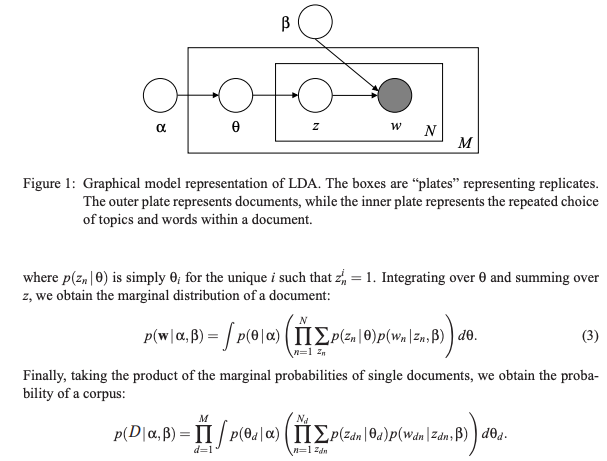

In [ ]:
## Recap LDA

Image('NLP_images/LDA_diagram.png', width=800)

## Load in the Reuters news corpus

This data can be obtained here:
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/reuters.zip

Please drop it into the folder NLP_data, using the directory structure shown below. Or just use the code in the next block to download the data and place it in the folder `NLP_data/reuters/`.  

Run this block only once to get the data. You do not need to re-run it once you have the news articles in your file system.

In [ ]:
%%time
os.system('wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/reuters.zip')
os.system('mv reuters.zip NLP_data/')
os.system('unzip NLP_data/reuters.zip')
os.system('mv reuters/ NLP_data/')
os.system('rm NLP_data/reuters.zip')

CPU times: user 632 ms, sys: 92.7 ms, total: 725 ms
Wall time: 2min 22s


0

## Text Cleaning Functions

Simple functions to remove numbers, punctuation, stopwords, and undertake stemming. We will use these to prepare the news articles downloaded above from Reuters.

In [ ]:
import nltk

# Remove punctuations
import string
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c," ")
    return s

def removePunc(text_array):
    return [removePuncStr(h) for h in text_array]

# Remove numbers
def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s

def removeNumbers(text_array):
    return [removeNumbersStr(h) for h in text_array]

# Stemming
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def stemText(text_array):
    stemmed_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            h2 = h2 + ' ' + PorterStemmer().stem(w)
        stemmed_text.append(h2)
    return stemmed_text

# Remove Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def stopText(text_array):
    stop_words = set(stopwords.words('english'))
    stopped_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            if w not in stop_words:
                h2 = h2 + ' ' + w
        stopped_text.append(h2)
    return stopped_text

# Write all docs to separate files
def write2textfile(s,filename):
    text_file = open(filename, "w")
    text_file.write(s)
    text_file.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Read in the corpus
from nltk.corpus import PlaintextCorpusReader
corpus_root = 'NLP_data/reuters/training/'
ctext = PlaintextCorpusReader(corpus_root, '.*')

In [ ]:
%%time
# Corpus Statistics
import nltk
nltk.download('punkt_tab')
print(len(ctext.fileids()))
print(len(ctext.paras()))
print(len(ctext.sents()))
print(len(ctext.words()))
print(len(ctext.raw()))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


7769
8471
40277
1253696
6478471
CPU times: user 16.1 s, sys: 7.13 s, total: 23.2 s
Wall time: 4min 8s


In [ ]:
#Convert corpus to text array with a full string for each doc
def merge_arrays(word_lists):
    wordlist = []
    for wl in word_lists:
        wordlist = wordlist + wl
    doc = ' '.join(wordlist)
    return doc

In [ ]:
#Run this through the corpus to get a word array for each doc
text_array = []
for p in ctext.paras():
    doc = merge_arrays(p)
    text_array.append(doc)

#Clean up the docs using the previous functions
news = text_array
news = removePunc(news)
news = removeNumbers(news)
news = stopText(news)
#news = stemText(news)
news = [j.lower() for j in news]
news[:2]

[' bahia cocoa review showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review the dry period means temporao late year arrivals week ended february bags kilos making cumulative total season mln stage last year again seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end with total bahia crop estimates around mln bags sales standing almost mln hundred thousand bags still hands farmers middlemen exporters processors there doubts much cocoa would fit export shippers experiencing dificulties obtaining bahia superior certificates in view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose cruzados per arroba kilos bean shippers reluctant offer nearby shipment limited sa

## Lemmatization

Stemming reduces words to their root form. The root form may not be an actual word in the language being processed. The goal of stemming is to reduce the number of forms of the word to a single form, so that when the term-document matrix is constructed, the same word does not appear as different words, as it may conflate the textual analysis being undertaken.

Stemming is a hard problem and a long-standing solution was developed by Porter in 1979. This has stood the test of time. https://tartarus.org/martin/PorterStemmer/. The Lancaster stemmer is more aggressive and was developed in 1990, the source code is quite economical and you can see it here: https://www.nltk.org/_modules/nltk/stem/lancaster.html

Lemmatization is the same as stemming with the additional constraint that the root word is present in the language's dictionary. NLTK uses the WordNet lemmatizer. (WordNet is a widely used word corpus also known as a "lexical database".) See: https://wordnet.princeton.edu/

Additional reading: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

def lemmText(text_array):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            h2 = h2 + ' ' + WNlemmatizer.lemmatize(w)
        lemmatized_text.append(h2)
    return lemmatized_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Example
import textwrap

bio = [' Citibank His current research interests include machine learning',
       ' social networks derivatives pricing models portfolio theory',
       ' modeling default risk systemic risk venture capital He',
       ' published hundred articles academic journals',
       ' numerous awards research teaching His recent book',
       ' Derivatives Principles Practice published May second edition']
temp = stopText(removeNumbers(removePunc(bio)))
print('Original: ',temp, "\n")
bio_lemm = lemmText(temp)
print('Lemmatized: ',bio_lemm, "\n")
bio_stem = stemText(temp)
print('Stemmed: ',bio_stem)

Original:  [' Citibank His current research interests include machine learning', ' social networks derivatives pricing models portfolio theory', ' modeling default risk systemic risk venture capital He', ' published hundred articles academic journals', ' numerous awards research teaching His recent book', ' Derivatives Principles Practice published May second edition'] 

Lemmatized:  [' Citibank His current research interest include machine learning', ' social network derivative pricing model portfolio theory', ' modeling default risk systemic risk venture capital He', ' published hundred article academic journal', ' numerous award research teaching His recent book', ' Derivatives Principles Practice published May second edition'] 

Stemmed:  [' citibank hi current research interest includ machin learn', ' social network deriv price model portfolio theori', ' model default risk system risk ventur capit he', ' publish hundr articl academ journal', ' numer award research teach hi recent 

In [ ]:
#Clean and process news documents into shape for LDA
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in news]

In [ ]:
print(len(doc_clean))
type(doc_clean)

8471


list

In [ ]:
for j in range(5):
    print(doc_clean[j])

['bahia', 'cocoa', 'review', 'shower', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospect', 'coming', 'temporao', 'although', 'normal', 'humidity', 'level', 'restored', 'comissaria', 'smith', 'said', 'weekly', 'review', 'dry', 'period', 'mean', 'temporao', 'late', 'year', 'arrival', 'week', 'ended', 'february', 'bag', 'kilo', 'making', 'cumulative', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seems', 'cocoa', 'delivered', 'earlier', 'consignment', 'included', 'arrival', 'figure', 'comissaria', 'smith', 'said', 'still', 'doubt', 'much', 'old', 'crop', 'cocoa', 'still', 'available', 'harvesting', 'practically', 'come', 'end', 'total', 'bahia', 'crop', 'estimate', 'around', 'mln', 'bag', 'sale', 'standing', 'almost', 'mln', 'hundred', 'thousand', 'bag', 'still', 'hand', 'farmer', 'middleman', 'exporter', 'processor', 'doubt', 'much', 'cocoa', 'would', 'fit', 'export', 'shipper', 'experiencing',

## Gensim for topic analysis

Stands for "generate similar".

https://radimrehurek.com/gensim/

There are several useful tutorials in this site. we will run the algorithm first and then discuss further two approaches for topic modeling.

In [ ]:
!pip install --upgrade smart_open
!pip install --upgrade gensim

In [ ]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our corpus, every unique term is assigned an index.
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
print(len(doc_term_matrix))
print(type(doc_term_matrix))
print(len(doc_term_matrix[0]))
print(len(doc_term_matrix[1]))

8471
<class 'list'>
149
86


In [ ]:
%%time
#RUN THE MODEL
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

CPU times: user 2min 24s, sys: 1.31 s, total: 2min 25s
Wall time: 2min 40s


In [ ]:
#Results
print(ldamodel.print_topics(num_topics=3, num_words=25))

[(0, '0.040*"said" + 0.020*"lt" + 0.019*"company" + 0.017*"share" + 0.016*"dlrs" + 0.010*"pct" + 0.010*"mln" + 0.009*"inc" + 0.009*"corp" + 0.007*"stock" + 0.006*"group" + 0.005*"offer" + 0.005*"co" + 0.005*"would" + 0.005*"unit" + 0.004*"sale" + 0.004*"also" + 0.004*"ltd" + 0.004*"new" + 0.004*"shareholder" + 0.004*"common" + 0.004*"acquisition" + 0.004*"one" + 0.004*"stake" + 0.004*"year"'), (1, '0.030*"said" + 0.015*"pct" + 0.012*"u" + 0.010*"year" + 0.009*"billion" + 0.009*"bank" + 0.008*"mln" + 0.007*"market" + 0.007*"trade" + 0.007*"would" + 0.006*"price" + 0.006*"rate" + 0.005*"oil" + 0.005*"tonne" + 0.005*"last" + 0.005*"dlrs" + 0.005*"export" + 0.004*"january" + 0.004*"february" + 0.004*"official" + 0.004*"japan" + 0.004*"month" + 0.004*"dollar" + 0.004*"government" + 0.004*"week"'), (2, '0.088*"v" + 0.078*"mln" + 0.056*"ct" + 0.043*"net" + 0.040*"loss" + 0.037*"dlrs" + 0.025*"shr" + 0.024*"profit" + 0.022*"year" + 0.022*"lt" + 0.016*"qtr" + 0.015*"rev" + 0.011*"sale" + 0.011*

## Two approaches to topic modeling:
    
[1] Latent Semantic Analysis (LSA): implements a matrix decomposition of the DTM $M$ into a $D$ matrix and an $T$, by minimizing the Frobenious norm, i.e.,

$$
\min || M - D \cdot T||_F
$$

Implemented with a truncated SVD.

[2] LDA: Latent Dirichlet Allocation (discussed above)

## LSA : Latent Semantic Analysis

See Linear Algebra Notebook 2: [022-LinearAlgebra_Eigensystems_Decompositions](https://drive.google.com/file/d/1apEJu2DtWh2spM_LNiV5aSrF_UenCVNH/view?usp=sharing)

https://srdas.github.io/MLBook2/24_TextAnaytics_Advanced.html#Singular-Value-Decomposition-(SVD)

See R code below.

In [ ]:
%%R
system("mkdir D")
write( c("blue", "red", "green"), file=paste("D", "D1.txt", sep="/"))
write( c("black", "blue", "red"), file=paste("D", "D2.txt", sep="/"))
write( c("yellow", "black", "green"), file=paste("D", "D3.txt", sep="/"))
write( c("yellow", "red", "black"), file=paste("D", "D4.txt", sep="/"))

In [ ]:
%%R
install.packages("lsa", quiet=TRUE)

In [ ]:
%%R
library(lsa)
tdm = textmatrix("D",minWordLength=1)
print(tdm)
system("rm -rf D")

        docs
terms    D1.txt D2.txt D3.txt D4.txt
  blue        1      1      0      0
  green       1      0      1      0
  red         1      1      0      1
  black       0      1      1      1
  yellow      0      0      1      1


## LSA and Singular Value Decomposition (SVD)

SVD tries to connect the correlation matrix of terms ($M \cdot M^\top$) with the correlation matrix of documents ($M^\top \cdot M$) through the singular matrix.

To see this connection, note that matrix $T$ contains the eigenvectors of the correlation matrix of terms. Likewise, the matrix $D$ contains the eigenvectors of the correlation matrix of documents. To see this, let’s compute

In [ ]:
%%R

# terms
et = eigen(tdm %*% t(tdm))$vectors
print(et)

# docs
ed = eigen(t(tdm) %*% tdm)$vectors
print(ed)

           [,1]          [,2]        [,3]         [,4]       [,5]
[1,] -0.3629044 -6.015010e-01 -0.06829369  3.71748e-01  0.6030227
[2,] -0.3328695  1.665335e-16 -0.89347008 -1.94289e-16 -0.3015113
[3,] -0.5593741 -3.717480e-01  0.31014767 -6.01501e-01 -0.3015113
[4,] -0.5593741  3.717480e-01  0.31014767  6.01501e-01 -0.3015113
[5,] -0.3629044  6.015010e-01 -0.06829369 -3.71748e-01  0.6030227
           [,1]      [,2]       [,3]      [,4]
[1,] -0.4570561  0.601501 -0.5395366 -0.371748
[2,] -0.5395366  0.371748  0.4570561  0.601501
[3,] -0.4570561 -0.601501 -0.5395366  0.371748
[4,] -0.5395366 -0.371748  0.4570561 -0.601501


## Dimension reduction of the TDM via LSA

If we wish to reduce the dimension of the latent semantic space to $k<n$ then we use only the first $k$ eigenvectors. The **lsa** function does this automatically.

We call LSA and ask it to automatically reduce the dimension of the TDM using a built-in function dimcalc_share.

In [ ]:
%%R
res = lsa(tdm,dims=dimcalc_share())
print(res)

$tk
             [,1]      [,2]
blue   -0.3629044 -0.601501
green  -0.3328695  0.000000
red    -0.5593741 -0.371748
black  -0.5593741  0.371748
yellow -0.3629044  0.601501

$dk
             [,1]      [,2]
D1.txt -0.4570561 -0.601501
D2.txt -0.5395366 -0.371748
D3.txt -0.4570561  0.601501
D4.txt -0.5395366  0.371748

$sk
[1] 2.746158 1.618034

attr(,"class")
[1] "LSAspace"


We can see that the dimension has been reduced from $n=4$ to $n=2$. The output is shown for both the term matrix and the document matrix, both of which have only two columns. Think of these as the two “principal semantic components” of the TDM.

Compare the output of the LSA to the eigenvectors above to see that it is exactly that. The singular values in the ouput are connected to SVD as follows.



## LSA and SVD: the connection?

First of all we see that the lsa function is nothing but the svd function.


In [ ]:
%%R
res2 = svd(tdm)
print(res2)

$d
[1] 2.746158 1.618034 1.207733 0.618034

$u
           [,1]      [,2]        [,3]          [,4]
[1,] -0.3629044 -0.601501 -0.06829369 -3.717480e-01
[2,] -0.3328695  0.000000 -0.89347008  3.538836e-15
[3,] -0.5593741 -0.371748  0.31014767  6.015010e-01
[4,] -0.5593741  0.371748  0.31014767 -6.015010e-01
[5,] -0.3629044  0.601501 -0.06829369  3.717480e-01

$v
           [,1]      [,2]       [,3]      [,4]
[1,] -0.4570561 -0.601501 -0.5395366  0.371748
[2,] -0.5395366 -0.371748  0.4570561 -0.601501
[3,] -0.4570561  0.601501 -0.5395366 -0.371748
[4,] -0.5395366  0.371748  0.4570561  0.601501



The output here is the same as that of LSA except it is provided for $n=4$. So we have four columns in $T$ and $D$ rather than two. Compare the results here to the previous two results to see the connection.

## What is the rank of the TDM?

We may reconstruct the TDM using the result of the LSA.

https://stattrek.com/matrix-algebra/matrix-rank.aspx

https://en.wikipedia.org/wiki/Rank_(linear_algebra)



In [ ]:
%%R
tdm_lsa = res$tk %*% diag(res$sk) %*% t(res$dk)
print(tdm_lsa)

           D1.txt    D2.txt     D3.txt    D4.txt
blue    1.0409089 0.8995016 -0.1299115 0.1758948
green   0.4178005 0.4931970  0.4178005 0.4931970
red     1.0639006 1.0524048  0.3402938 0.6051912
black   0.3402938 0.6051912  1.0639006 1.0524048
yellow -0.1299115 0.1758948  1.0409089 0.8995016


What is the rank of the TDM after LSA?

In [ ]:
%%R
library(Matrix)
print(rankMatrix(tdm_lsa))

[1] 2
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 1.110223e-15


Compare this to the rank of the TDM before LSA

In [ ]:
%%R
library(Matrix)
print(rankMatrix(tdm))

[1] 4
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 1.110223e-15


## text2vec for topic analysis

A very useful, high performance library for topic modeling and other text analysis.

Code here is adapted from: http://text2vec.org/topic_modeling.html

May need: `conda install -c conda-forge r-text2vec` or the R install below.

In [ ]:
%%R
install.packages(c("text2vec", "stringr"), quiet=TRUE)

In [ ]:
%%R
# Use text2vec to create the DTM
library(stringr)
library(text2vec)
data("movie_review")
# select 1000 rows for faster running times
movie_review_train = movie_review[1:700, ]
movie_review_test = movie_review[701:1000, ]
prep_fun = function(x) {
  # make text lower case
  x = str_to_lower(x)
  # remove non-alphanumeric symbols
  x = str_replace_all(x, "[^[:alpha:]]", " ")
  # collapse multiple spaces
  x = str_replace_all(x, "\\s+", " ")
}
movie_review_train$review = prep_fun(movie_review_train$review)
it = itoken(movie_review_train$review, progressbar = FALSE)
v = create_vocabulary(it)
v = prune_vocabulary(v, doc_proportion_max = 0.1, term_count_min = 5)
vectorizer = vocab_vectorizer(v)
dtm = create_dtm(it, vectorizer)

In [ ]:
%%R
# Perform tf-idf scaling and fit LSA model:

tfidf = TfIdf$new()
lsa = LSA$new(n_topics = 10)

# pipe friendly transformation
doc_embeddings =  fit_transform(dtm, tfidf)
doc_embeddings =  fit_transform(doc_embeddings, lsa)
dim(doc_embeddings)

INFO  [04:57:36.784] soft_als: iter 001, frobenious norm change 2.240 loss NA
INFO  [04:57:36.861] soft_als: iter 002, frobenious norm change 1.134 loss NA
INFO  [04:57:36.889] soft_als: iter 003, frobenious norm change 0.111 loss NA
INFO  [04:57:36.903] soft_als: iter 004, frobenious norm change 0.041 loss NA
INFO  [04:57:36.917] soft_als: iter 005, frobenious norm change 0.020 loss NA
INFO  [04:57:36.931] soft_als: iter 006, frobenious norm change 0.012 loss NA
INFO  [04:57:36.949] soft_als: iter 007, frobenious norm change 0.008 loss NA
INFO  [04:57:36.965] soft_als: iter 008, frobenious norm change 0.005 loss NA
INFO  [04:57:37.011] soft_als: iter 009, frobenious norm change 0.004 loss NA
INFO  [04:57:37.024] soft_als: iter 010, frobenious norm change 0.003 loss NA
INFO  [04:57:37.037] soft_als: iter 011, frobenious norm change 0.002 loss NA
INFO  [04:57:37.051] soft_als: iter 012, frobenious norm change 0.001 loss NA
INFO  [04:57:37.079] soft_als: iter 013, frobenious norm change 

In [ ]:
%%R
# LDA
tokens = tolower(movie_review$review[1:4000])
tokens = word_tokenizer(tokens)
it = itoken(tokens, ids = movie_review$id[1:4000], progressbar = FALSE)
v = create_vocabulary(it)
v = prune_vocabulary(v, term_count_min = 10, doc_proportion_max = 0.2)

vectorizer = vocab_vectorizer(v)
dtm = create_dtm(it, vectorizer, type = "dgTMatrix")

lda_model = LDA$new(n_topics = 10, doc_topic_prior = 0.1, topic_word_prior = 0.01)
doc_topic_distr = lda_model$fit_transform(x = dtm, n_iter = 1000,
                  convergence_tol = 0.001, n_check_convergence = 25,
                  progressbar = FALSE)

INFO  [04:57:47.558] early stopping at 225 iteration
INFO  [04:57:50.351] early stopping at 50 iteration


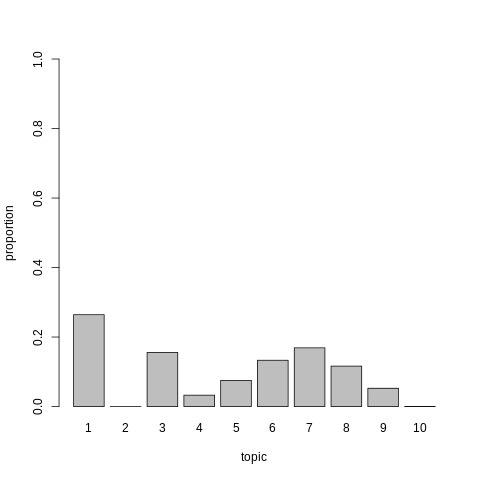

In [ ]:
%%R
barplot(doc_topic_distr[1, ], xlab = "topic",
        ylab = "proportion", ylim = c(0, 1),
        names.arg = 1:ncol(doc_topic_distr))

In [ ]:
%%R
# top words for each topic sorted by probability of observing the word in a given topic (lambda = 1):
lda_model$get_top_words(n = 10, topic_number = c(3L, 6L, 7L), lambda = 1)

      [,1]        [,2]        [,3]    
 [1,] "show"      "scene"     "your"  
 [2,] "best"      "where"     "love"  
 [3,] "actors"    "character" "still" 
 [4,] "love"      "doesn't"   "s"     
 [5,] "play"      "these"     "know"  
 [6,] "better"    "does"      "old"   
 [7,] "did"       "woman"     "funny" 
 [8,] "years"     "down"      "now"   
 [9,] "character" "little"    "years" 
[10,] "funny"     "while"     "comedy"


In [ ]:
%%R
# Sorted by “relevance” which takes into account frequency of words in the corpus (0 < lambda < 1).
lda_model$get_top_words(n = 10, topic_number = c(3L, 6L, 7L), lambda = 0.2)

      [,1]      [,2]       [,3]     
 [1,] "show"    "zombies"  "victor" 
 [2,] "disney"  "water"    "fu"     
 [3,] "animals" "page"     "alien"  
 [4,] "burns"   "japanese" "edie"   
 [5,] "king"    "marie"    "n"      
 [6,] "sing"    "cowboy"   "planet" 
 [7,] "elvis"   "teenage"  "ha"     
 [8,] "eddie"   "beach"    "kung"   
 [9,] "golden"  "meets"    "anime"  
[10,] "scooby"  "core"     "lincoln"


## Perplexity

A [language model](https://en.wikipedia.org/wiki/Language_model) generates the probability of a sequence of words.

Perplexity is the inverse probability of a data set of words $W=\{w_1,w_2,...,w_N\}$, normalized by the number of words $N$, i.e.,

$$
Px(W) = \frac{1}{Pr[w_1,w_2,...,w_N]^{1/N}} = 2^{-\frac{1}{N} \log_2 Pr[w_1,w_2,...,w_N]}
$$

This metric arises in the context of language models. The best language models predict an unseen test set, so Px is computed on the test data set. For this purpose, we assume that

$$
Pr[w_1,w_2,...,w_N] = \prod_{i=1}^n Pr[w_i | w_1,w_2,...,w_{i-1}]
$$

For unigrams, it will be

$$
Pr[w_1,w_2,...,w_N] = \prod_{i=1}^n Pr[w_i]
$$

For bigrams, it will be

$$
Pr[w_1,w_2,...,w_N] = \prod_{i=1}^n Pr[w_i | w_{i-1}]
$$

## Relation to Cross-Entropy

We are interested in knowing how well a language model captures the way in which text is generated. How much of the order of the test data set of text is seen in the lens of the language model? This is nothing but asking about the cross-entropy of the model.

Cross-entropy for a probability density $Pr$ is the expected number of bits needed to encode the information in text $x$

$$
H(Pr,Pred) = E[\log_2 Pred(x)] = -\sum_{i=1}^N Pr(x) \log_2 Pred(x)
$$

where $Pred(x)$ is the predicted probability of word $x$.

See: http://srdas.github.io/MLBook2/28_DeepLearning_Introduction.html#More-on-Cross-Entropy

The perplexity of the distribution is simply

$$
Px(Pr,Pred) = 2^{H(Pr,Pred)}
$$

Assuming that all words are equally likely to occur, $Pr(x)=\frac{1}{N}$, which is a contestable assumption, we get

$$
Px(Pr,Pred) = 2^{-\frac{1}{N} \sum_{i=1}^N \log_2 Pred(x)}
$$

which is analogous to the formula for Px above.

Here is a really nice blog on it: https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

## Perplexity of a topic model

https://rdrr.io/cran/text2vec/man/perplexity.html

What does this mean?

- Take a document $d$
- See which topic it has the highest probability for
- Get the probability of words in that topic (this is a $n$ vector, where $n$ is the vocab size), $p_0$.
- Get the normalized count vector (divided by count vector total) for the document, $p$.
- Compute perplexity: $Px(p_0,p)$

We can compute perplexity for different number of topics to see which one has the lowest perplexity.

We may ask, why not use entropy itself? Since entropy is log-scaled, we are just rescaling back to the size of the word itself, which may be more natural to understand (unless you are digital native).

Apply the model to new data and obtain document-topic distribution, then compute perplexity.

In [ ]:
%%R
it = itoken(movie_review$review[4001:5000], tolower, word_tokenizer, ids = movie_review$id[4001:5000])
new_dtm =  create_dtm(it, vectorizer, type = "dgTMatrix")
new_doc_topic_distr = lda_model$transform(new_dtm)

px = perplexity(new_dtm, topic_word_distribution = lda_model$topic_word_distribution,
           doc_topic_distribution = new_doc_topic_distr)
print(c(px, log2(px)))  # the second number is the number of bits entropy

  |======================================================================| 100%INFO  [04:57:52.347] early stopping at 40 iteration

[1] 2570.55524   11.32786


In [ ]:
%%R
it = itoken(movie_review$review[1:1000], tolower, word_tokenizer, ids = movie_review$id[1:1000])
new_dtm =  create_dtm(it, vectorizer, type = "dgTMatrix")
new_doc_topic_distr = lda_model$transform(new_dtm)

px = perplexity(new_dtm, topic_word_distribution = lda_model$topic_word_distribution,
           doc_topic_distribution = new_doc_topic_distr)
print(c(px, log2(px)))  # the second number is the number of bits entropy

  |======================================================================| 100%INFO  [04:57:53.237] early stopping at 30 iteration

[1] 2475.58812   11.27356


In [ ]:
%%R
# Decomposition of the DTM
print(dim(new_dtm))
print(dim(new_doc_topic_distr))
print(dim(lda_model$topic_word_distribution))

[1] 1000 6565
[1] 1000   10
[1]   10 6565


In [ ]:
%%R
# Check the document probability adds up across topics
print(length(rowSums(new_doc_topic_distr)))
print(rowSums(new_doc_topic_distr[1:20,]))

[1] 1000
 5814_8  2381_9  7759_3  3630_4  9495_8  8196_8  7166_2 10633_1   319_1 8713_10 
      1       1       1       1       1       1       1       1       1       1 
 2486_3 6811_10 11744_9  7369_1 12081_1  3561_4  4489_1  3951_2 3304_10 9352_10 
      1       1       1       1       1       1       1       1       1       1 


In [ ]:
%%R
# Check that the probability of words with topics adds up
# print(lda_model$topic_word_distribution[1,])
print(rowSums(lda_model$topic_word_distribution))

 [1] 1 1 1 1 1 1 1 1 1 1
